In [565]:
%load_ext autoreload
%autoreload 2
import espaloma as esp
import torch
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [583]:
from simtk import unit
GAS_CONSTANT = 8.31446261815324 * unit.joule / (unit.kelvin * unit.mole)
GAS_CONSTANT = GAS_CONSTANT.value_in_unit(
    esp.units.ENERGY_UNIT / (unit.kelvin)
)
kT = GAS_CONSTANT * 100

In [584]:
WINDOWS = 20

In [585]:
def leapfrog(xs, vs, closure, dt=1.0):
    x = xs[-1]
    v = vs[-1]

    x = x + v * dt

    energy_old = closure(x)

    a = -torch.autograd.grad(
        energy_old.sum(),
        [x],
        create_graph=True,
        retain_graph=True,
    )[0]

    v = v + a * dt

    x = x + v * dt

    vs.append(v)
    xs.append(x)

    return xs, vs

In [586]:
g = esp.Graph('CC')
g = esp.graphs.LegacyForceField('smirnoff99Frosst').parametrize(g)

In [587]:
layer = esp.nn.dgl_legacy.gn()

representation = esp.nn.Sequential(
    layer,
    [32, 'leaky_relu', 128, 'leaky_relu', 128, 'leaky_relu'],
)

readout = esp.nn.readout.janossy.JanossyPooling(
    in_features=128,
    config=[128, 'leaky_relu', 128, 'leaky_relu'],
    out_features={
        1: {'epsilons': WINDOWS, 'sigma': 1, 'log_alpha': WINDOWS},
        2: {'ks': WINDOWS, 'eqs': WINDOWS},
        3: {'ks': WINDOWS, 'eqs': WINDOWS},
    }
)


net = torch.nn.Sequential(
    representation,
    readout,
)

realize = torch.nn.Sequential(
    esp.mm.geometry.GeometryInGraph(),
    esp.mm.energy.EnergyInGraph(suffix='_ref', terms=['n2', 'n3']),
)


In [588]:
def closure(x, idx, g=g):
    with g.heterograph.local_scope():
        g.nodes['n1'].data['xyz'] = x
        
        
        if idx != -1:

            g.nodes['n2'].data['eq_ref'] = g.nodes['n2'].data['eqs'][:, idx][:, None].exp()
            g.nodes['n2'].data['k_ref'] = g.nodes['n2'].data['ks'][:, idx][:, None].exp()

            g.nodes['n3'].data['eq_ref'] = g.nodes['n3'].data['eqs'][:, idx][:, None].exp()
            g.nodes['n3'].data['k_ref'] = g.nodes['n3'].data['ks'][:, idx][:, None].exp()
            
        realize(g.heterograph)
        return g.nodes['g'].data['u_ref']



In [589]:
def simulation(net, g=g):
    with g.heterograph.local_scope():
        net(g.heterograph)
        
        log_alpha = g.nodes['n1'].data['log_alpha']
        
        det_j = log_alpha.sum(dim=-1)
        
        x0_distribution = torch.distributions.normal.Normal(
            loc=torch.zeros(g.heterograph.number_of_nodes('n1'), 128, 3),
            scale=g.nodes['n1'].data['sigma'][:, :, None].repeat(1, 128, 3).exp()
        )
        
        normal_distribution = torch.distributions.normal.Normal(0, 1.0)
        
        x = torch.nn.Parameter(
            x0_distribution.rsample()
        )
        
        v = torch.nn.Parameter(
            normal_distribution.rsample(
                sample_shape=(g.heterograph.number_of_nodes('n1'), 128, 3),
            )
        )
        
        xs = [x]
        vs = [v]

        for idx in range(1, WINDOWS):
            
            alpha = g.heterograph.nodes['n1'].data['log_alpha'][:, idx].exp()
            
            
            vs[-1] = vs[-1] * alpha[:, None, None].repeat(1, 128, 3)

            xs, vs = leapfrog(xs, vs, lambda x: closure(x, idx, g=g), 1e-2)
            
        return xs, vs, x0_distribution, det_j
    

In [590]:
optimizer = torch.optim.Adam(net.parameters(), 1e-5)
normal_distribution = torch.distributions.normal.Normal(0, 1.0)

for _ in range(1000):
    optimizer.zero_grad()
    
    xs, vs, x0_distribution, det_j = simulation(net)
    
    energy = closure(xs[-1], idx=-1).sum()
    
    log_p = -energy/kT + normal_distribution.log_prob(vs[-1]).sum()
    
    log_q = -det_j.sum() * 3 + normal_distribution.log_prob(vs[0]).sum() + x0_distribution.log_prob(xs[0]).sum()
        
    loss = -log_p + log_q
    
    loss.backward()
    
    print(loss, energy)
    
    optimizer.step()

tensor(692047.0625, grad_fn=<AddBackward0>) tensor(220.4890, grad_fn=<SumBackward0>)
tensor(678104.8125, grad_fn=<AddBackward0>) tensor(216.0744, grad_fn=<SumBackward0>)
tensor(676757.7500, grad_fn=<AddBackward0>) tensor(215.6292, grad_fn=<SumBackward0>)
tensor(698891.3750, grad_fn=<AddBackward0>) tensor(222.6654, grad_fn=<SumBackward0>)
tensor(711689.4375, grad_fn=<AddBackward0>) tensor(226.7283, grad_fn=<SumBackward0>)
tensor(682037.3750, grad_fn=<AddBackward0>) tensor(217.3112, grad_fn=<SumBackward0>)
tensor(679493.4375, grad_fn=<AddBackward0>) tensor(216.5321, grad_fn=<SumBackward0>)
tensor(705563.6875, grad_fn=<AddBackward0>) tensor(224.7747, grad_fn=<SumBackward0>)
tensor(675196.6250, grad_fn=<AddBackward0>) tensor(215.1838, grad_fn=<SumBackward0>)
tensor(683526.1875, grad_fn=<AddBackward0>) tensor(217.7725, grad_fn=<SumBackward0>)
tensor(712141.8125, grad_fn=<AddBackward0>) tensor(226.8586, grad_fn=<SumBackward0>)
tensor(696719.8750, grad_fn=<AddBackward0>) tensor(221.9681, grad

tensor(710943.1250, grad_fn=<AddBackward0>) tensor(226.5313, grad_fn=<SumBackward0>)
tensor(677759.3750, grad_fn=<AddBackward0>) tensor(216.0126, grad_fn=<SumBackward0>)
tensor(696880.0625, grad_fn=<AddBackward0>) tensor(222.0813, grad_fn=<SumBackward0>)
tensor(678589., grad_fn=<AddBackward0>) tensor(216.2636, grad_fn=<SumBackward0>)
tensor(703897.7500, grad_fn=<AddBackward0>) tensor(224.2740, grad_fn=<SumBackward0>)
tensor(699991.5000, grad_fn=<AddBackward0>) tensor(223.0583, grad_fn=<SumBackward0>)
tensor(669615.6250, grad_fn=<AddBackward0>) tensor(213.4151, grad_fn=<SumBackward0>)
tensor(689949., grad_fn=<AddBackward0>) tensor(219.8888, grad_fn=<SumBackward0>)
tensor(663527., grad_fn=<AddBackward0>) tensor(211.5061, grad_fn=<SumBackward0>)
tensor(714100.6875, grad_fn=<AddBackward0>) tensor(227.5244, grad_fn=<SumBackward0>)
tensor(664065.7500, grad_fn=<AddBackward0>) tensor(211.6542, grad_fn=<SumBackward0>)
tensor(694262.9375, grad_fn=<AddBackward0>) tensor(221.2455, grad_fn=<SumBack

tensor(672200.9375, grad_fn=<AddBackward0>) tensor(214.2614, grad_fn=<SumBackward0>)
tensor(684730.7500, grad_fn=<AddBackward0>) tensor(218.2350, grad_fn=<SumBackward0>)
tensor(637429.3750, grad_fn=<AddBackward0>) tensor(203.2231, grad_fn=<SumBackward0>)
tensor(697445.9375, grad_fn=<AddBackward0>) tensor(222.2672, grad_fn=<SumBackward0>)
tensor(668829.8125, grad_fn=<AddBackward0>) tensor(213.1721, grad_fn=<SumBackward0>)
tensor(681700.4375, grad_fn=<AddBackward0>) tensor(217.2567, grad_fn=<SumBackward0>)
tensor(665894.5000, grad_fn=<AddBackward0>) tensor(212.2390, grad_fn=<SumBackward0>)
tensor(664668.0625, grad_fn=<AddBackward0>) tensor(211.8493, grad_fn=<SumBackward0>)
tensor(692245.5625, grad_fn=<AddBackward0>) tensor(220.6028, grad_fn=<SumBackward0>)
tensor(642055.3750, grad_fn=<AddBackward0>) tensor(204.7174, grad_fn=<SumBackward0>)
tensor(667246.5625, grad_fn=<AddBackward0>) tensor(212.6812, grad_fn=<SumBackward0>)
tensor(685639.6250, grad_fn=<AddBackward0>) tensor(218.5030, grad

tensor(647510.0625, grad_fn=<AddBackward0>) tensor(206.3195, grad_fn=<SumBackward0>)
tensor(647541.7500, grad_fn=<AddBackward0>) tensor(206.3565, grad_fn=<SumBackward0>)
tensor(649638.5000, grad_fn=<AddBackward0>) tensor(207.0047, grad_fn=<SumBackward0>)
tensor(681393.5625, grad_fn=<AddBackward0>) tensor(217.0705, grad_fn=<SumBackward0>)
tensor(670561.8750, grad_fn=<AddBackward0>) tensor(213.6316, grad_fn=<SumBackward0>)
tensor(646760.0625, grad_fn=<AddBackward0>) tensor(206.0765, grad_fn=<SumBackward0>)
tensor(673011.6875, grad_fn=<AddBackward0>) tensor(214.3960, grad_fn=<SumBackward0>)
tensor(644005.1875, grad_fn=<AddBackward0>) tensor(205.1999, grad_fn=<SumBackward0>)
tensor(667657.2500, grad_fn=<AddBackward0>) tensor(212.6836, grad_fn=<SumBackward0>)
tensor(643888.0625, grad_fn=<AddBackward0>) tensor(205.2027, grad_fn=<SumBackward0>)
tensor(668689.8750, grad_fn=<AddBackward0>) tensor(213.0445, grad_fn=<SumBackward0>)
tensor(686717.6875, grad_fn=<AddBackward0>) tensor(218.7411, grad

tensor(537738., grad_fn=<AddBackward0>) tensor(169.0965, grad_fn=<SumBackward0>)
tensor(577483.3125, grad_fn=<AddBackward0>) tensor(181.6254, grad_fn=<SumBackward0>)
tensor(551067., grad_fn=<AddBackward0>) tensor(173.4243, grad_fn=<SumBackward0>)
tensor(612607.6250, grad_fn=<AddBackward0>) tensor(192.5208, grad_fn=<SumBackward0>)
tensor(562516.6250, grad_fn=<AddBackward0>) tensor(177.2191, grad_fn=<SumBackward0>)
tensor(547503.2500, grad_fn=<AddBackward0>) tensor(172.4715, grad_fn=<SumBackward0>)
tensor(550957.3125, grad_fn=<AddBackward0>) tensor(173.8830, grad_fn=<SumBackward0>)
tensor(551321.1875, grad_fn=<AddBackward0>) tensor(173.9652, grad_fn=<SumBackward0>)
tensor(527857.6875, grad_fn=<AddBackward0>) tensor(166.5405, grad_fn=<SumBackward0>)
tensor(562620.5625, grad_fn=<AddBackward0>) tensor(177.6690, grad_fn=<SumBackward0>)
tensor(540362.1875, grad_fn=<AddBackward0>) tensor(170.7261, grad_fn=<SumBackward0>)
tensor(562123.1250, grad_fn=<AddBackward0>) tensor(177.5763, grad_fn=<Sum

tensor(499023.8750, grad_fn=<AddBackward0>) tensor(157.3339, grad_fn=<SumBackward0>)
tensor(516590.2812, grad_fn=<AddBackward0>) tensor(162.8741, grad_fn=<SumBackward0>)
tensor(532953.5000, grad_fn=<AddBackward0>) tensor(167.9922, grad_fn=<SumBackward0>)
tensor(527891.6250, grad_fn=<AddBackward0>) tensor(166.4652, grad_fn=<SumBackward0>)
tensor(522769.1562, grad_fn=<AddBackward0>) tensor(164.9516, grad_fn=<SumBackward0>)
tensor(515532.4688, grad_fn=<AddBackward0>) tensor(162.7191, grad_fn=<SumBackward0>)
tensor(511187.6875, grad_fn=<AddBackward0>) tensor(161.1781, grad_fn=<SumBackward0>)
tensor(523136.8438, grad_fn=<AddBackward0>) tensor(164.9557, grad_fn=<SumBackward0>)
tensor(515922.5000, grad_fn=<AddBackward0>) tensor(162.6273, grad_fn=<SumBackward0>)
tensor(534572.6875, grad_fn=<AddBackward0>) tensor(168.8588, grad_fn=<SumBackward0>)
tensor(512893.5312, grad_fn=<AddBackward0>) tensor(161.8757, grad_fn=<SumBackward0>)
tensor(519493.5938, grad_fn=<AddBackward0>) tensor(163.9362, grad

tensor(497808.8125, grad_fn=<AddBackward0>) tensor(157.0738, grad_fn=<SumBackward0>)
tensor(526146.0625, grad_fn=<AddBackward0>) tensor(166.0571, grad_fn=<SumBackward0>)
tensor(506659.4062, grad_fn=<AddBackward0>) tensor(159.9553, grad_fn=<SumBackward0>)
tensor(520935.1250, grad_fn=<AddBackward0>) tensor(164.5005, grad_fn=<SumBackward0>)
tensor(516638.9375, grad_fn=<AddBackward0>) tensor(163.2320, grad_fn=<SumBackward0>)
tensor(513636., grad_fn=<AddBackward0>) tensor(162.0695, grad_fn=<SumBackward0>)
tensor(512281.3125, grad_fn=<AddBackward0>) tensor(161.5989, grad_fn=<SumBackward0>)
tensor(514154.4062, grad_fn=<AddBackward0>) tensor(162.3782, grad_fn=<SumBackward0>)
tensor(519946., grad_fn=<AddBackward0>) tensor(164.1726, grad_fn=<SumBackward0>)
tensor(528104.6250, grad_fn=<AddBackward0>) tensor(166.7377, grad_fn=<SumBackward0>)
tensor(512023.2812, grad_fn=<AddBackward0>) tensor(161.6822, grad_fn=<SumBackward0>)
tensor(488390.8125, grad_fn=<AddBackward0>) tensor(154.1080, grad_fn=<Sum

KeyboardInterrupt: 

In [574]:
xs, vs, particle_distribution, _ = simulation(net)


In [575]:
import nglview as nv
from rdkit.Geometry import Point3D
from rdkit import Chem
from rdkit.Chem import AllChem

conf_idx = 1

mol = g.mol.to_rdkit()
AllChem.EmbedMolecule(mol)
conf = mol.GetConformer()

xs, vs, particle_distribution, _ = simulation(net)
x = xs[-1]


for idx_atom in range(mol.GetNumAtoms()):
    conf.SetAtomPosition(
        idx_atom,
        Point3D(
            float(x[idx_atom, conf_idx, 0]),
            float(x[idx_atom, conf_idx, 1]),
            float(x[idx_atom, conf_idx, 2]),
        ))
    
nv.show_rdkit(mol)

NGLWidget()

In [522]:
g = esp.Graph('CC')
g = esp.graphs.LegacyForceField('smirnoff99Frosst').parametrize(g)
g.nodes['n1'].data['xyz'] = xs[-1]
realize(g.heterograph)

Graph(num_nodes={'g': 1, 'n1': 8, 'n2': 14, 'n3': 24, 'n4': 18, 'nonbonded': 0, 'onefour': 18},
      num_edges={('g', 'g_has_n1', 'n1'): 8, ('g', 'g_has_n2', 'n2'): 14, ('g', 'g_has_n3', 'n3'): 24, ('g', 'g_has_n4', 'n4'): 18, ('g', 'g_has_nonbonded', 'nonbonded'): 0, ('g', 'g_has_onefour', 'onefour'): 18, ('n1', 'n1_as_0_in_n2', 'n2'): 14, ('n1', 'n1_as_0_in_n3', 'n3'): 24, ('n1', 'n1_as_0_in_n4', 'n4'): 18, ('n1', 'n1_as_0_in_nonbonded', 'nonbonded'): 0, ('n1', 'n1_as_0_in_onefour', 'onefour'): 18, ('n1', 'n1_as_1_in_n2', 'n2'): 14, ('n1', 'n1_as_1_in_n3', 'n3'): 24, ('n1', 'n1_as_1_in_n4', 'n4'): 18, ('n1', 'n1_as_1_in_nonbonded', 'nonbonded'): 0, ('n1', 'n1_as_1_in_onefour', 'onefour'): 18, ('n1', 'n1_as_2_in_n3', 'n3'): 24, ('n1', 'n1_as_2_in_n4', 'n4'): 18, ('n1', 'n1_as_3_in_n4', 'n4'): 18, ('n1', 'n1_in_g', 'g'): 8, ('n1', 'n1_neighbors_n1', 'n1'): 14, ('n2', 'n2_as_0_in_n3', 'n3'): 24, ('n2', 'n2_as_0_in_n4', 'n4'): 18, ('n2', 'n2_as_1_in_n3', 'n3'): 24, ('n2', 'n2_as_1_in_n4

In [ ]:
from matplotlib import pyplot as plt
plt.hist(
    g.nodes['n3'].data['x'].flatten().detach().numpy()
)

In [593]:
import openforcefield

In [596]:
from espaloma.data.md import MoleculeVacuumSimulation
simulation = MoleculeVacuumSimulation(
    n_samples=128, n_steps_per_sample=10,
)
g = esp.Graph('C')
g = esp.graphs.LegacyForceField('smirnoff99Frosst').parametrize(g)
simulation.run(g, in_place=True)


/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


(array([ 18.,  48., 116., 216., 250., 224.,  98.,  46.,   4.,   4.]),
 array([1.899204 , 1.9360824, 1.9729607, 2.009839 , 2.0467174, 2.0835958,
        2.120474 , 2.1573524, 2.1942308, 2.2311091, 2.2679875],
       dtype=float32),
 <a list of 10 Patch objects>)

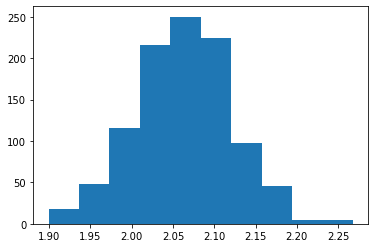

In [599]:
from matplotlib import pyplot as plt
esp.mm.geometry.geometry_in_graph(g.heterograph)
plt.hist(
    g.nodes['n2'].data['x'].flatten().cpu().detach().numpy()
)

(array([  6.,  42.,  82., 216., 328., 412., 276., 120.,  38.,  16.]),
 array([1.6291838, 1.6830696, 1.7369553, 1.7908411, 1.8447268, 1.8986126,
        1.9524984, 2.0063841, 2.0602698, 2.1141558, 2.1680415],
       dtype=float32),
 <a list of 10 Patch objects>)

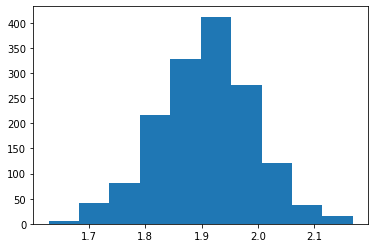

In [600]:
from matplotlib import pyplot as plt
esp.mm.geometry.geometry_in_graph(g.heterograph)
plt.hist(
    g.nodes['n3'].data['x'].flatten().cpu().detach().numpy()
)